#  Сегментация изображений

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ClothesSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        """
        Инициализация датасета.
        :param image_dir: Путь к директории с изображениями.
        :param mask_dir: Путь к директории с масками.
        :param image_transform: Преобразования для изображений.
        :param mask_transform: Преобразования для масок.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Получаем список файлов в директориях
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

        assert len(self.image_names) == len(self.mask_names), "Количество изображений и масок не совпадает!"

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Получение изображения и маски по индексу.
        :param idx: Индекс.
        :return: (image_tensor, mask_tensor)
        """
        # Загружаем изображение и маску
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path).convert("RGB")  # Открываем изображение
        mask = Image.open(mask_path).convert("L")    # Открываем маску в оттенках серого

        # Применяем преобразования, если они указаны
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = transforms.ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)  # Преобразуем в тензор

        # Убедимся, что маска - целочисленный тензор
        mask = (mask * 255).long()

        return image, mask

In [ ]:
# Пути к изображениям и маскам
image_dir = "/content/drive/MyDrive/IMAGES"
mask_dir = "/content/drive/MyDrive/MASKS"

# Преобразования для изображений и масок
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Создаем объект датасета
dataset = ClothesSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)

# Проверяем форму и типы одного примера
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Image dtype: {image.dtype}")
print(f"Mask shape: {mask.shape}, Mask dtype: {mask.dtype}")

Image shape: torch.Size([3, 256, 256]), Image dtype: torch.float32
Mask shape: torch.Size([1, 256, 256]), Mask dtype: torch.int64


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

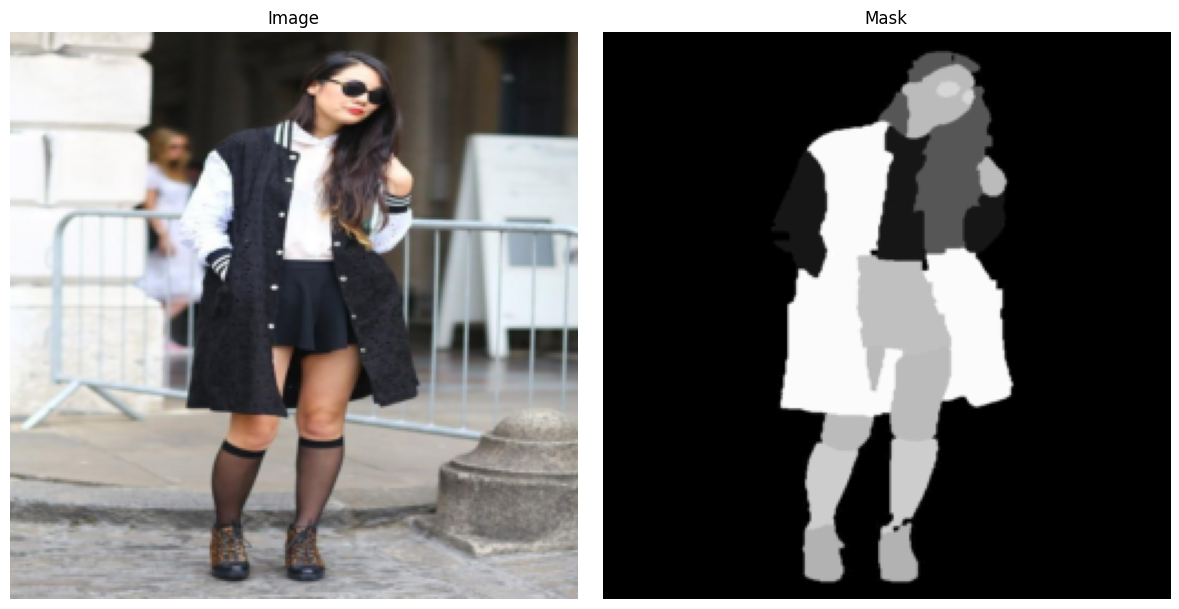

In [ ]:
import matplotlib.pyplot as plt

def show_image_with_mask(image, mask):
    """
    Отображает изображение и маску рядом.
    :param image: Тензор изображения (C, H, W).
    :param mask: Тензор маски (H, W) или (1, H, W).
    """
    # Преобразуем тензоры в форматы, подходящие для отображения
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    mask = mask.squeeze(0).numpy()         # (1, H, W) -> (H, W) или оставляем (H, W)

    # Создаем фигуру и отображаем изображения
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Пример использования
image, mask = dataset[0]  # Берем первый пример из датасета
show_image_with_mask(image, mask)

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [ ]:
import os
import numpy as np
from PIL import Image

def count_classes(mask_dir):
    unique_values = set()
    for mask_name in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_name)
        mask = Image.open(mask_path).convert("L")  # Маска в оттенках серого
        unique_values.update(np.unique(np.array(mask)))
    return len(unique_values), unique_values

# Подсчёт уникальных классов в масках
n_classes, unique_values = count_classes("/content/drive/MyDrive/MASKS")
print(f"Number of classes: {n_classes}")
print(f"Unique values in masks: {unique_values}")

Number of classes: 66
Unique values in masks: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65}


In [ ]:
from torchvision import transforms

# Пути к данным
image_dir = "/content/drive/MyDrive/IMAGES"
mask_dir = "/content/drive/MyDrive/MASKS"

# Преобразования
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),  # Обеспечиваем одинаковый размер
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация для ImageNet
])

# Преобразования для масок с Resize
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),  # Маски тоже должны быть одного размера с изображениями
    transforms.ToTensor(),
])

# Создаем объект датасета
dataset = ClothesSegmentationDataset(image_dir, mask_dir, transform_image, transform_mask)

In [ ]:
image, mask = dataset[0]  # Берем первый пример
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=66):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch, use_batchnorm=True, use_dropout=True):
            layers = [
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch) if use_batchnorm else nn.Identity(),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch) if use_batchnorm else nn.Identity(),
            ]
            if use_dropout:
                layers.append(nn.Dropout(0.3))  # Использование Dropout
            return nn.Sequential(*layers)

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.center = conv_block(512, 1024, use_batchnorm=False)  # No BatchNorm in center block

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        center = self.center(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

# Создаём модель и переносим на CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, n_classes=66).to(device)

In [ ]:
# Берём один пример из датасета
image, mask = dataset[0]
image = image.unsqueeze(0).to(device)  # Добавляем размер батча и переносим на CUDA

# Пропускаем через модель
output = model(image)

# Проверяем форму выходного тензора
print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 66, 256, 256])


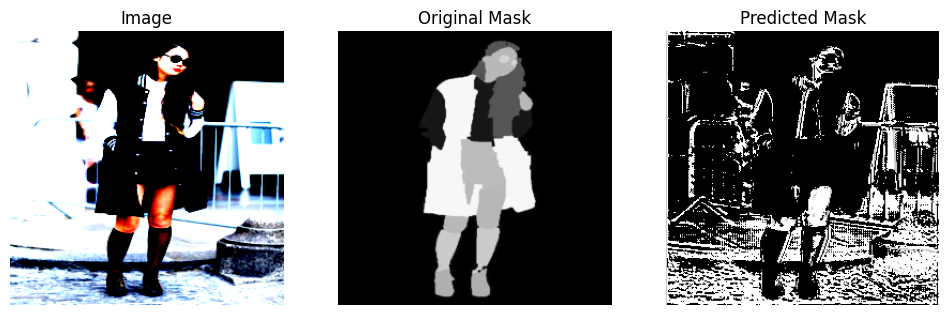

In [ ]:
# Переводим предсказание в классы
predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Визуализируем
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Оригинальное изображение
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("Image")
plt.axis("off")

# Оригинальная маска
plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(0).numpy(), cmap="gray")
plt.title("Original Mask")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [ ]:
from sklearn.model_selection import train_test_split

# Пути к изображениям и маскам
image_dir = "/content/drive/MyDrive/IMAGES"
mask_dir = "/content/drive/MyDrive/MASKS"

# Получаем список файлов
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Разделяем данные
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Проверяем размеры выборок
print("Train size:", len(train_images))
print("Validation size:", len(val_images))

Train size: 800
Validation size: 200


In [ ]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_names, image_transform=None, mask_transform=None):
        """
        :param image_dir: Директория с изображениями
        :param mask_dir: Директория с масками
        :param file_names: Список имён файлов (без разделения на train/val)
        :param image_transform: Преобразования для изображений
        :param mask_transform: Преобразования для масок
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_names = file_names
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Извлекаем имя файла
        file_name = self.file_names[idx]

        # Пути к изображениям и маскам
        img_path = os.path.join(self.image_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name.replace("img", "seg"))  # Маски должны совпадать

        # Загружаем изображения и маски
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Преобразования
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = transforms.ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        # Маска должна быть целочисленной
        mask = (mask * 255).long()

        return image, mask


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Преобразования изображений с нормализацией
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
])

# Преобразования для масок
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Маски остаются как есть
])

# Пути к папкам с изображениями и масками
train_image_dir = "/content/drive/MyDrive/IMAGES"
train_mask_dir = "/content/drive/MyDrive/MASKS"

# Датасеты для обучения и валидации
train_dataset = ClothesSegmentationDataset(
    train_image_dir, train_mask_dir, train_images, image_transform, mask_transform
)

val_dataset = ClothesSegmentationDataset(
    train_image_dir, train_mask_dir, val_images, image_transform, mask_transform
)

# Даталоадеры
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Проверка
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 800
Validation dataset size: 200


In [ ]:
# Подсчёт количества пикселей каждого класса
from collections import Counter
import numpy as np

def compute_class_weights(mask_dir, n_classes):
    total_pixels = 0
    class_counts = Counter()

    for mask_name in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_name)
        mask = np.array(Image.open(mask_path).convert("L"))
        class_counts.update(mask.flatten())
        total_pixels += mask.size

    # Вычисляем веса: 1 / (доля пикселей + небольшое смещение)
    weights = []
    for cls in range(n_classes):
        count = class_counts[cls]
        weight = 1.0 / (count / total_pixels + 1e-6) if count > 0 else 0.0
        weights.append(weight)

    return torch.tensor(weights)

# Настройка весов
n_classes = 66  # Число классов
weights = compute_class_weights(mask_dir, n_classes).to(device)
print("Class weights:", weights)

Class weights: tensor([1.3127e+00, 2.1446e+02, 1.0039e+02, 5.6215e+02, 1.5518e+02, 1.1967e+02,
        7.4188e+02, 8.4004e+02, 6.3748e+03, 4.8079e+03, 3.6922e+02, 9.1481e+02,
        1.1121e+03, 4.2084e+01, 3.7774e+01, 1.2619e+03, 2.4376e+03, 2.1127e+03,
        9.8874e+02, 1.0154e+02, 5.8517e+02, 1.9969e+03, 2.4157e+03, 2.9337e+03,
        2.2892e+02, 1.0029e+02, 7.5464e+02, 6.4233e+02, 2.6074e+03, 2.9204e+03,
        1.3574e+03, 4.4936e+01, 1.1022e+03, 2.5640e+02, 2.4423e+03, 3.9135e+02,
        1.0939e+03, 3.7029e+02, 1.4563e+02, 1.3066e+02, 2.3324e+02, 4.1473e+01,
        1.0155e+02, 8.6620e+02, 1.2770e+03, 3.8983e+02, 1.4318e+02, 1.2031e+03,
        1.7790e+02, 7.3195e+02, 3.9812e+03, 2.4145e+02, 3.7829e+03, 3.0958e+03,
        5.8727e+02, 4.3322e+02, 4.9212e+03, 1.4810e+04, 2.4057e+04, 7.7634e+04,
        1.8682e+05, 3.8923e+05, 6.4021e+05, 9.0977e+05, 9.5577e+05, 9.9780e+05],
       device='cuda:0')


In [ ]:
weights[0] = 0.0  # Задаём нулевой вес для фона
criterion = nn.CrossEntropyLoss(weight=weights)  # Обновляем функцию потерь

In [ ]:
def compute_accuracy(preds, targets):
    """
    Вычисляет точность сегментации (Accuracy).
    :param preds: Предсказания модели (тензор с индексами классов).
    :param targets: Истинные маски (тензор с индексами классов).
    :return: Значение точности.
    """
    preds = preds.flatten()  # Разворачиваем тензор в вектор
    targets = targets.flatten()
    correct = (preds == targets).sum().item()  # Количество правильных предсказаний
    total = targets.numel()  # Общее количество элементов
    return correct / total


In [ ]:
# Параметры обучения
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.squeeze(1).to(device)  # Перенос на CUDA
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()  # Обратный проход
        optimizer.step()

        # Обновляем статистику
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc += compute_accuracy(preds, masks)

    # Среднее значение для эпохи
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Валидация
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.squeeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            # Обновляем статистику
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_acc += compute_accuracy(preds, masks)

    # Среднее значение для эпохи
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Вывод результатов за эпоху
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


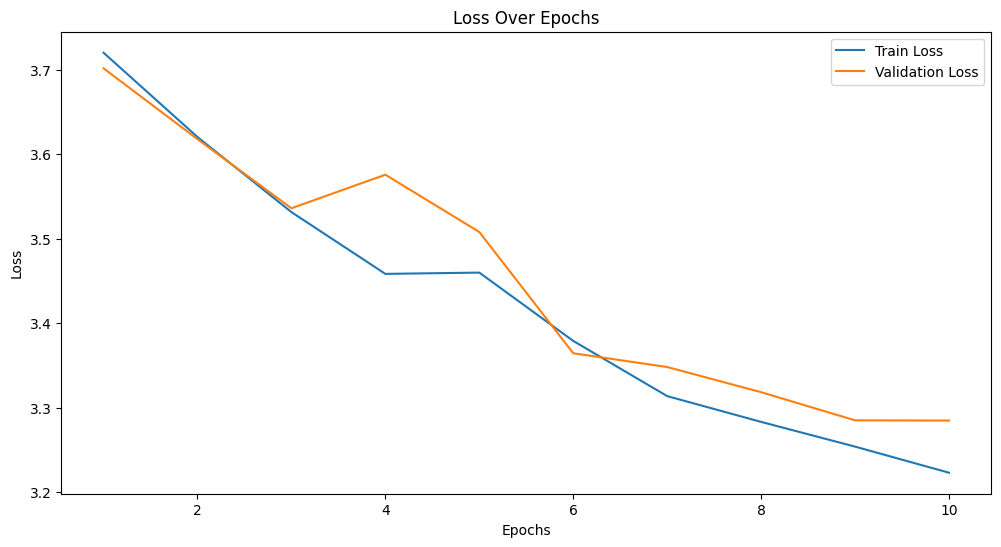

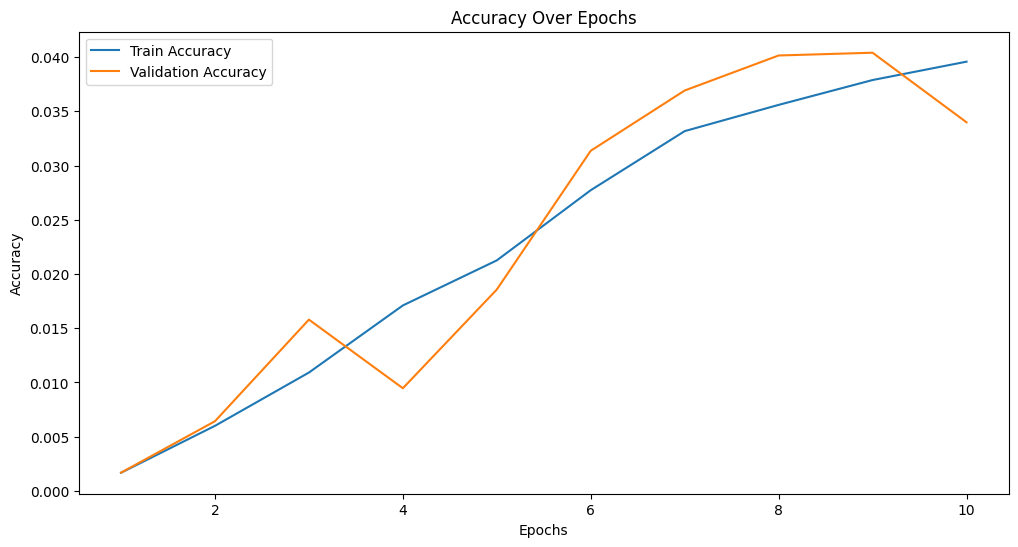

In [ ]:
import matplotlib.pyplot as plt

# График функции потерь
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# График точности
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()


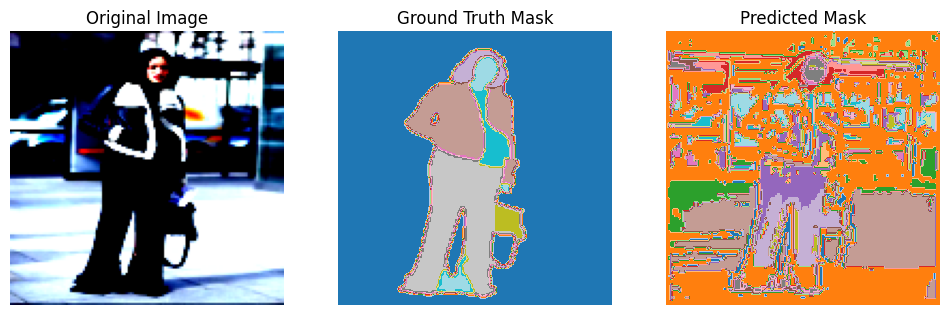

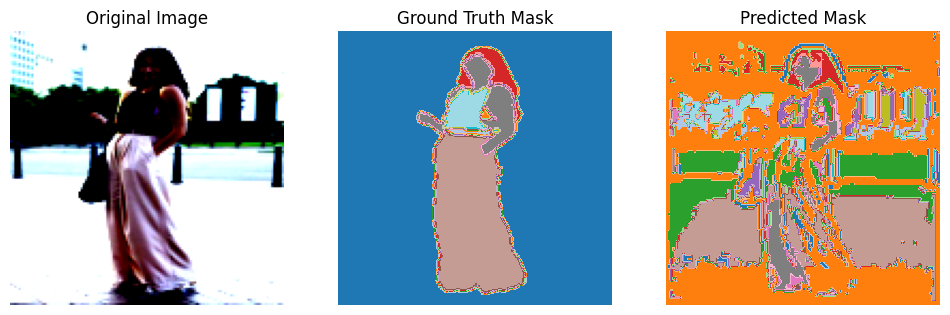

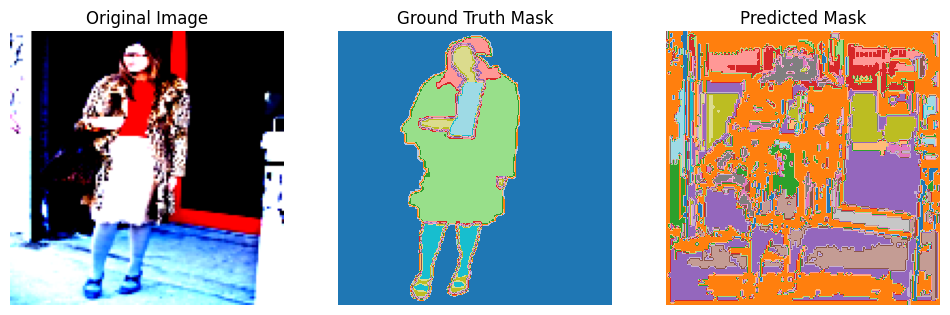

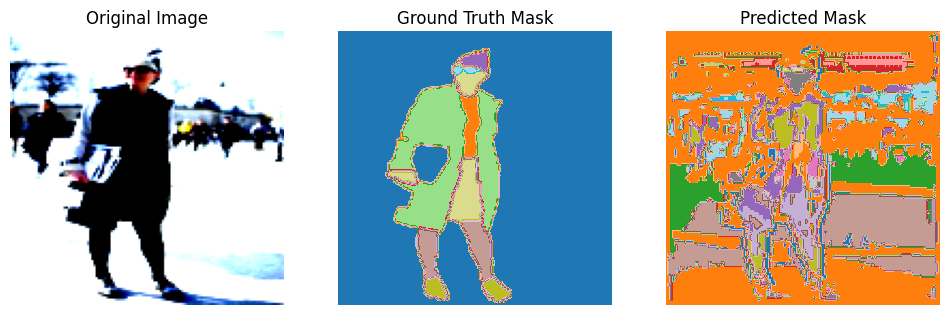

In [ ]:
# Визуализация предсказаний
model.eval()

for i, (image, mask) in enumerate(val_loader):
    image, mask = image.to(device), mask.squeeze(1).to(device)
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy()
        original_image = image.cpu().numpy()
        mask = mask.cpu().numpy()

    # Визуализация
    for j in range(min(4, len(image))):  # Показываем до 4 изображений из батча
        plt.figure(figsize=(12, 4))

        # Оригинальное изображение
        plt.subplot(1, 3, 1)
        plt.imshow(original_image[j].transpose(1, 2, 0))  # RGB формат
        plt.title("Original Image")
        plt.axis("off")

        # Истинная маска
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap="tab20")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Предсказанная маска (без фона)
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap="tab20")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()
    break  # Останавливаемся после первого батча
